# Generating synthetic tracking sequences from static images

## Introduction

In [34]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
import IPython.display
import tracking.TrajectorySimulator as trsim
import animator
from PIL import Image
import os

In order to generate a reasonable amount of training sequences to the tracking model, we plan to generate them artificially. The first approach leverages previously segmented objects from static images, and moves them over a background given by another image that mimics a scene. So, even though the simulated movements and segmented objects are limited, we may generate a large amount of simulations that may help the model infer complex types of motions. If our hypothesis are correct, we may be able to track arbitrary objects on an image sequence, with minimal human intervention to generate tracking ground truth information.

In [36]:
reload(trsim)

<module 'tracking.TrajectorySimulator' from '/home/fmpaezri/repos/localization-agent/tracking/TrajectorySimulator.pyc'>

In [37]:
# Generates a factory to create random simulator instances from COCO
%time cocoFactory =  trsim.COCOSimulatorFactory('/home/fmpaezri/datasets/labelme', trajectoryModelPath='gmmDenseAbsoluteNormalizedOOT.pkl', summaryPath='/home/fmpaezri/Downloads/votSummary.pkl', scenePathTemplate='', objectPathTemplate='')

Loading summary from file /home/fmpaezri/Downloads/votSummary.pkl
CPU times: user 72 ms, sys: 12 ms, total: 84 ms
Wall time: 83.6 ms


In [41]:
emptyPolygon = True
while emptyPolygon:
    simulator = cocoFactory.createInstance(drawBox=True, camera=True, drawCam=True, cameraContentTransforms=None)
    emptyPolygon = len(simulator.polygon) == 0

Segmenting object from category fish
@TrajectorySimulator: New simulation with scene /home/fmpaezri/datasets/labelme/fish_10.jpg and object /home/fmpaezri/datasets/labelme/fish_3.jpg


In [42]:
simulator.start()

In [43]:
output = '/tmp/simulation.mp4'
%time animator.frames2video(simulator, 30, output, piped=False)
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
videoTag = '<video controls autoplay width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
IPython.display.HTML(videoTag.format(videoSrc))

CPU times: user 496 ms, sys: 680 ms, total: 1.18 s
Wall time: 515 ms


In [21]:
simulator.step = 1
simulator.camera=False
output = '/tmp/simulation.mp4'
%time animator.frames2video(simulator, 30, output, piped=False)
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
videoTag = '<video controls autoplay width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
IPython.display.HTML(videoTag.format(videoSrc))

CPU times: user 868 ms, sys: 1.21 s, total: 2.08 s
Wall time: 778 ms


(224, 224)
(177, 143)
(640, 427)
(640, 427)


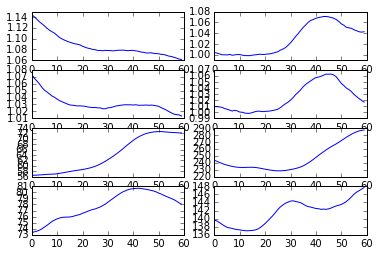

In [226]:
print simulator.camSize
print simulator.objSize
print simulator.sceneSize
print simulator.objView.size
for index, trans in enumerate(simulator.contentTransforms):
    subplot(len(simulator.contentTransforms), 2, 2*(index)+1)
    plot(trans.X)
for index, trans in enumerate(simulator.cameraContentTransforms):
    subplot(len(simulator.cameraContentTransforms), 2, 2*index+2)
    plot(trans.X)

In [5]:
# Creates a simulator using predefined images and transformation functions
#camSize = Image.open('/home/fmpaezri/datasets/vot-challenge/sequences/ball/00000000.jpg').size
contentTransforms = [
    trsim.Transformation(trsim.scaleX, 1, 2, pathFunction=linspace),
    trsim.Transformation(trsim.scaleY, 1, 4, pathFunction=linspace),
    trsim.Transformation(trsim.rotate, 0, pi/2, pathFunction=linspace),
    trsim.Transformation(trsim.translateX, 40, 200, pathFunction=linspace),
    trsim.Transformation(trsim.translateY, 40, 200, pathFunction=linspace),
        ]
shapeTransforms =  [
    trsim.Transformation(trsim.identityShape, 1, 1, pathFunction=linspace),
]
cameraContentTransforms = [
]
cameraShapeTransforms = [
    trsim.Transformation(trsim.identityShape, 1, 1, pathFunction=linspace),
]

scenePath = '/home/fmpaezri/datasets/vot-challenge/sequences/ball/00000000.jpg'
objectPath = '/home/fmpaezri/datasets/vot-challenge/sequences/basketball/00000001.jpg'

polygon = map(int, map(float, open(os.path.join(os.path.dirname(objectPath),'groundtruth.txt')).readlines()[0].strip().split(',')))

simulator = trsim.TrajectorySimulator(\
    scenePath,\
    objectPath,\
    [], polygon=polygon, camSize=(150,120),\
    axes=True,\
    contentTransforms=contentTransforms, shapeTransforms=shapeTransforms,\
    cameraContentTransforms=cameraContentTransforms, cameraShapeTransforms=cameraShapeTransforms,\
    drawBox=True, drawCam=True, camera=True)

IOError: [Errno 2] No such file or directory: '/home/fmpaezri/datasets/vot-challenge/sequences/basketball/groundtruth.txt'

In [5]:
#Creates a simulator from specific input images
#simulator = cocoFactory.create(\
#                               '/home/datasets/datasets1/mscoco//images/train2014/COCO_train2014_000000066299.jpg',\
#                               '/home/datasets/datasets1/mscoco//images/train2014/COCO_train2014_000000467579.jpg', axes=True)

In [6]:
# Draws axes on the image origin
def show_axes():
    annotate('', xy=(0.4,0.9), xytext=(0.1,0.9), size=30, xycoords='axes fraction', textcoords='axes fraction', \
         arrowprops=dict(arrowstyle='simple', relpos=(0,0), fc=(1.0, 0.0, 0.0), ec=(1.0, 1.0, 0.0)))
    annotate('', xy=(0.1,0.6), xytext=(0.1,0.9), size=30, xycoords='axes fraction', textcoords='axes fraction', \
         arrowprops=dict(arrowstyle='simple', relpos=(0,0), fc=(0.0, 0.0, 1.0), ec=(1.0, 1.0, 0.0)))

The simulation starts by selecting a scene and an object image. In the following figure a sample scene, object and segmentation are presented.

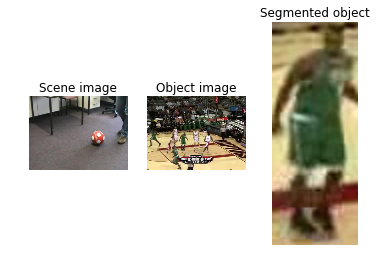

In [5]:
subplot(1,3,1)
axis('off')
imshow(imread(scenePath))
title('Scene image')

objectImage = imread(objectPath)
subplot(1,3,2)
axis('off')
imshow(objectImage)
title('Object image')

subplot(1,3,3)
axis('off')
imshow(objectImage[min(polygon[1::2]):max(polygon[1::2]), min(polygon[0::2]):max(polygon[0::2])])
title('Segmented object')

##Modeling the sequence

The type of motions considered are those provided by general projective transformations, i.e. translation, rotation, scaling, shearing. By modeling movements as a succession of projective operations, we obtain a solid mathematical formulation of the motion. A planar projective transform from coordinate frame $a$ to $b$ is of the type
$$T_{a}^{b}=\begin{bmatrix} t_{1,1} & t_{1,2} & t_{1,3} \\ t_{2,1} & t_{2,2} & t_{2,3} \\ t_{3,1} & t_{3,2} & t_{3,3} \end{bmatrix}$$
where we are assuming use of homogeneous coordinates that allows handling rotations and translations under the same matrix-paradigm. The homogeneous coordinates are build by adding a third coordinate to the planar $x$ and $y$ coordinates, resulting in a new point $h$
$$h=\begin{bmatrix} x \\ y \\ z \end{bmatrix}$$

Using homogeneous coordinates, one can chain fine grained transformations into a complex single transformation. For example, the rotation by a $\theta$ angle, scaling by an $s$ factor and translation by $(t_{x}, t_{y})$ matrices are given by
$$R(\theta)_{a}^{b}=\begin{bmatrix} cos(\theta) & sin(\theta) & 0 \\ -sin(\theta) & cos(\theta) & 0 \\ 0 & 0 & 1 \end{bmatrix}$$
$$S(s)_{a}^{b}=\begin{bmatrix} s & 0 & 0 \\ 0 & s & 0 \\ 0 & 0 & 1 \end{bmatrix}$$
$$Tr(x,y)_{a}^{b}=\begin{bmatrix} 1 & 0 & t_{x} \\ 0 & 1 & t_{y} \\ 0 & 0 & 1 \end{bmatrix}$$

Which may be grouped in a single matrix T by multiplying on the desired order (as the transformations are not conmutative). For example, first rotating, then scaling and finally translating may be condensed as
$$T(x,y,s,̣\theta)=Tr(x,y)*S(s)*R(\theta)$$

A sequence may be described as an object moving over a scene viewed by a camera that also has its own motion. First lets think of the scene as a canvas were we are going to move the object, so we can create a coordinate system attached to the scene, which is going to be our absolute coordinate system. Then we apply a transformation $T_{object}(x,y,s,\theta)$ (as defined above) to the object in order to place it inside the scene, and we obtain a synthetic scene. Finally, to simulate camera movement we take a crop from the synthetic scene, but is taken after applying another transformation $T_{camera}(x,y,s,\theta)$ to the synthetic scene. This last transformation defines the point of view of the camera.

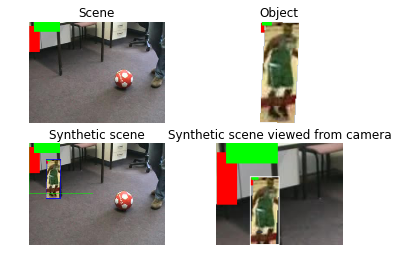

In [6]:
#Read a scene image and draw the CS
subplot(2,2,1)
axis('off')
imshow(asarray(simulator.scene))
title('Scene')
subplot(2,2,2)
axis('off')
imshow(asarray(simulator.obj))
title('Object')
subplot(2,2,3)
axis('off')
imshow(asarray(simulator.sceneView))
title('Synthetic scene')
subplot(2,2,4)
axis('off')
imshow(asarray(simulator.camView))
title('Synthetic scene viewed from camera')

A simple way to invert a transformation is by taking the inverse of the transformation matrix. For example, to generate a simulation where the camera follows exactly the object may be generated by specifying the inverses each object transformation applied in the inverse order. The following video presents an object moving along the scene diagonal while it rotates 90° counter clock wise. The inverse transformations have been applied in reverse order to the camera, making it follow the moving object.

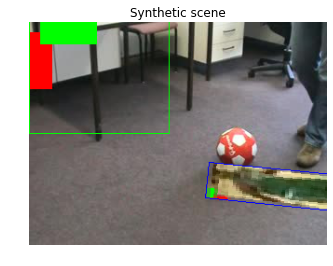

In [10]:
axis('off')
imshow(asarray(simulator.sceneView))
title('Synthetic scene')

The following video shows the same moving object but followed by a camera with random sinusoidal transformations around the location of the object.

In [11]:
contentTransforms = [
    trsim.Transformation(trsim.scaleX, 1, 2, pathFunction=linspace),
    trsim.Transformation(trsim.scaleY, 1, 4, pathFunction=linspace),
    trsim.Transformation(trsim.rotate, 0, pi/2, pathFunction=linspace),
    trsim.Transformation(trsim.translateX, 40, 100, pathFunction=linspace),
    trsim.Transformation(trsim.translateY, 40, 100, pathFunction=linspace),
        ]
shapeTransforms =  [
    trsim.Transformation(trsim.identityShape, 1, 1, pathFunction=linspace),
]
cameraContentTransforms = [
    #trsim.Transformation(trsim.rotation, -pi/10, pi/10, pathFunction=linspace),
    trsim.Transformation(trsim.translateY, 0, -10, pathFunction=linspace),
    trsim.Transformation(trsim.translateX, 0, -20, pathFunction=linspace),
    #trsim.Transformation(trsim.scaleY, 0.6, 1.4, pathFunction=linspace),
    #trsim.Transformation(trsim.scaleX, 0.6, 1.4, pathFunction=linspace),
]
cameraShapeTransforms = [
    trsim.Transformation(trsim.identityShape, 1, 1, pathFunction=linspace),
]

polygon = map(int, map(float, open(os.path.join(os.path.dirname(objectPath),'groundtruth.txt')).readlines()[0].strip().split(',')))
simulator = trsim.TrajectorySimulator(\
    scenePath,\
    objectPath,\
    [], polygon=polygon, camSize=(150,120),\
    axes=True,\
    contentTransforms=contentTransforms, shapeTransforms=shapeTransforms,\
    cameraContentTransforms=cameraContentTransforms, cameraShapeTransforms=cameraShapeTransforms,\
    drawBox=True, drawCam=True, camera=True)

@TrajectorySimulator: New simulation with scene /home/fmpaezri/datasets/vot-challenge/sequences/ball/00000000.jpg and object /home/fmpaezri/datasets/vot-challenge/sequences/basketball/00000001.jpg


In [12]:
output = '/tmp/simulationSine.mp4'
%time animator.frames2video(simulator, 30, output)
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
IPython.display.HTML(videoTag.format(videoSrc))

CPU times: user 176 ms, sys: 4 ms, total: 180 ms
Wall time: 262 ms


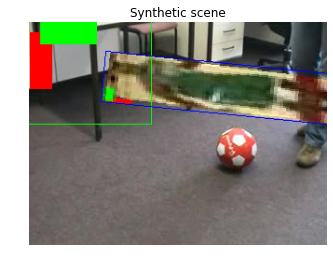

In [13]:
axis('off')
imshow(asarray(simulator.sceneView))
title('Synthetic scene')

Now, the same type of transformation sequence but with parameters from a sinusoidal function.

In [14]:
contentTransforms = [
    trsim.Transformation(trsim.scaleX, 0.5, 2),
    trsim.Transformation(trsim.scaleY, 0.5, 2),
    trsim.Transformation(trsim.rotate, -pi, pi),
    trsim.Transformation(trsim.translateX, 0, 280),
    trsim.Transformation(trsim.translateY, 0, 200),
]
shapeTransforms =  [
    trsim.Transformation(trsim.identityShape, 1, 1),
]
cameraContentTransforms = [
    trsim.Transformation(trsim.rotate, -pi/5, pi/5),
    trsim.Transformation(trsim.scaleY, 0.6, 1.4),
    trsim.Transformation(trsim.scaleX, 0.6, 1.4),
    trsim.Transformation(trsim.translateX, 0, -50),
    trsim.Transformation(trsim.translateY, 0, -40),
]
cameraShapeTransforms = [
    trsim.Transformation(trsim.identityShape, 1, 1, pathFunction=linspace),
]

polygon = map(int, map(float, open(os.path.join(os.path.dirname(objectPath),'groundtruth.txt')).readlines()[0].strip().split(',')))
simulator = trsim.TrajectorySimulator(\
    scenePath,\
    objectPath,\
    [], polygon=polygon, camSize=(150,120),\
    axes=True,\
    contentTransforms=contentTransforms, shapeTransforms=shapeTransforms,\
    cameraContentTransforms=cameraContentTransforms, cameraShapeTransforms=cameraShapeTransforms,\
    drawBox=True, drawCam=True, camera=True)

@TrajectorySimulator: New simulation with scene /home/fmpaezri/datasets/vot-challenge/sequences/ball/00000000.jpg and object /home/fmpaezri/datasets/vot-challenge/sequences/basketball/00000001.jpg


In [15]:
output = '/tmp/simulationSine.mp4'
%time animator.frames2video(simulator, 30, output)
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
IPython.display.HTML(videoTag.format(videoSrc))

CPU times: user 172 ms, sys: 8 ms, total: 180 ms
Wall time: 279 ms


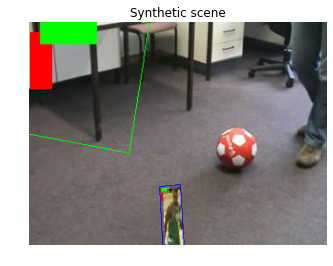

In [16]:
axis('off')
imshow(asarray(simulator.sceneView))
title('Synthetic scene')

In [50]:
reload(trsim)

<module 'tracking.TrajectorySimulator' from '/home/fmpaezri/repos/localization-agent/tracking/TrajectorySimulator.py'>

In [16]:
polygon = map(int, map(float, open(os.path.join(os.path.dirname(objectPath),'groundtruth.txt')).readlines()[0].strip().split(',')))
simulator = trsim.TrajectorySimulator(\
    scenePath,\
    objectPath,\
    [], polygon=polygon, camSize=(100,100),\
    axes=True,\
    drawBox=True, drawCam=True, camera=False)

@TrajectorySimulator: New simulation with scene /home/fmpaezri/datasets/vot-challenge/sequences/ball/00000000.jpg and object /home/fmpaezri/datasets/vot-challenge/sequences/basketball/00000001.jpg


In [16]:
while simulator.nextStep(): simulator.saveFrame('/tmp/')

In [5]:
output = '/tmp/simulationSine.mp4'
%time animator.frames2video(simulator, 30, output)
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
IPython.display.HTML(videoTag.format(videoSrc))

Translation bounds: [36.602540378443862, 36.602540378443862] to [178.57864376269049, 98.57864376269049]
Rotation bounds: -0.261799387799 to 0.261799387799
Scale bounds: 0.8 to 1.0
@TrajectorySimulator: New simulation with scene /home/fmpaezri/datasets/vot-challenge/sequences/ball/00000000.jpg and object /home/fmpaezri/datasets/vot-challenge/sequences/basketball/00000001.jpg
CPU times: user 132 ms, sys: 4 ms, total: 136 ms
Wall time: 216 ms


In [41]:
polygon = map(int, map(float, open(os.path.join(os.path.dirname(objectPath),'groundtruth.txt')).readlines()[0].strip().split(',')))
simulator = trsim.TrajectorySimulator(\
    scenePath,\
    objectPath,\
    [], polygon=polygon, camSize=(100,100),\
    axes=True,\
    drawBox=True, drawCam=False, camera=False, trajectoryModelPath='gmmDenseAbsoluteNormalized.pkl',\
    cameraContentTransforms=[])
output = '/tmp/simulationGMM.mp4'
%time animator.frames2video(simulator, 30, output)
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
IPython.display.HTML(videoTag.format(videoSrc))

@TrajectorySimulator: New simulation with scene /home/fmpaezri/datasets/vot-challenge/sequences/ball/00000000.jpg and object /home/fmpaezri/datasets/vot-challenge/sequences/basketball/00000001.jpg
CPU times: user 248 ms, sys: 12 ms, total: 260 ms
Wall time: 366 ms
